In [23]:
import logging
import os
import pathlib
import time

import hydra
from omegaconf import DictConfig
from collections.abc import MutableMapping
import wandb

import scanpy as sc
import pandas as pd

from trainer import train_model
from evaluator import evaluate_model
from data.graph_augmentation_prep import *
from data.dataset import OurDataset
from data.augmentations import * #get_transforms, augmentations
from data.graph_augmentation_prep import * # builders for mnn and bbknn augmentation.

import torch
import torch.backends.cudnn as cudnn
from torchvision.transforms import Compose
import numpy as np
import random
import lightning as pl

import yaml

_LOGGER = logging.getLogger(__name__)
with open("/local/home/tomap/scAugmentBench/conf/augmentation/clear_pipeline.yaml") as stream:
    cfg_aug = yaml.safe_load(stream)
with open("/local/home/tomap/scAugmentBench/conf/data/immune.yaml") as stream:
#with open("/local/home/tomap/scAugmentBench/conf/data/pbmc_2_donor.yaml") as stream:
    cfg_data = yaml.safe_load(stream)
with open("/local/home/tomap/scAugmentBench/conf/model/simclr.yaml") as stream:
    cfg_model = yaml.safe_load(stream)

cfg = {}
cfg['data'] = cfg_data
cfg['data']['n_hvgs'] = 4000
cfg['model'] = cfg_model
cfg['model']['in_dim'] = 4000
cfg['augmentation'] = cfg_aug

In [24]:
from main import load_data

train, val, adata = load_data(cfg)

/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:489: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hvg = pd.concat([hvg, missing_hvg], ignore_index=True)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_

In [3]:
import lightning as pl
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)

model = train_model(dataset=train, 
                        model_config=cfg["model"],
                        random_seed=0, 
                        batch_size=256,
                        num_workers=14,
                        n_epochs=100,
                        logger=root)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 512 K 
1 | projection_head | SimCLRProjectionHead | 18.2 K
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
530 K     Trainable params
0         Non-trainable params
530 K     Total params
2.122     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
from main import evaluate_model

results, embedding = evaluate_model(model=model,
                                        dataset=val,
                                        adata=adata,
                                        batch_size=256,
                                        num_workers=1,)

results

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

,Isolated labels,Leiden NMI,Leiden ARI,KBET,Graph connectivity,Batch correction,Bio conservation,Total
Embedding,,,,,,,,
Embedding,0.641,0.772,0.671,0.332,0.859,0.595,0.695,0.655


/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  col

[<Axes: title={'center': 'CellType'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batchlb'}, xlabel='UMAP1', ylabel='UMAP2'>]

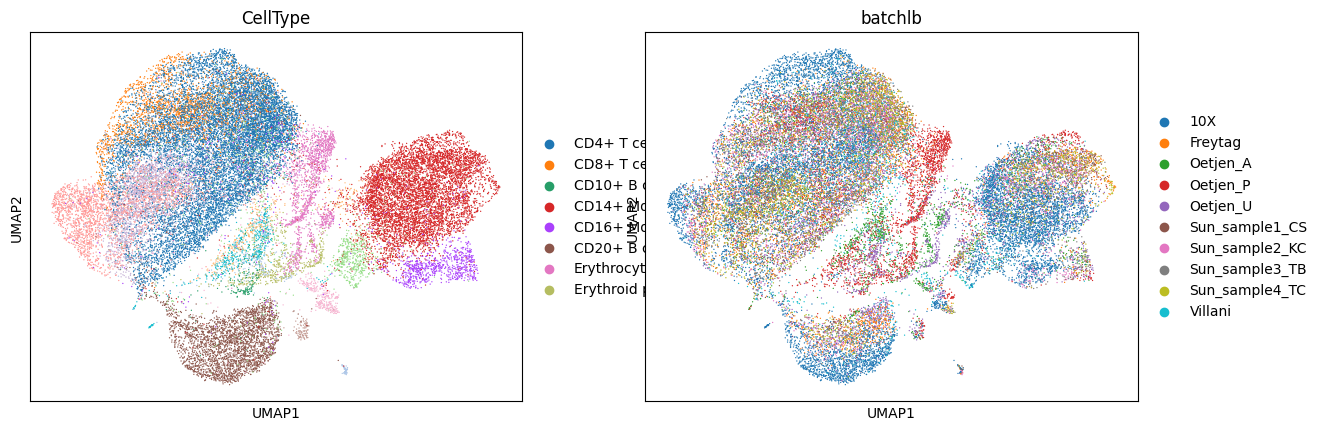

In [37]:
import scanpy as sc
import numpy as np

def plot_umap(adata, embedding):
    adata.obsm['Embedding'] = embedding
    sc.pp.neighbors(adata, use_rep="Embedding")
    sc.tl.umap(adata)
    return sc.pl.umap(adata, show=False, color=['CellType', 'batchlb'],)

path = "/local/home/tomap/scAugmentBench/dimension-ablation-vol2/ImmHuman/SimSiam/256-256/20/embedding.npz"

embedding = np.load(path)['arr_0']
plot_umap(adata, embedding)

In [119]:
from evaluator import collect_runs, unify_table, scale_table



,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
BarlowTwins,0.4667,0.5337,0.4380,0.5090,0.9790,0.8275,0.1083,0.1153,0.7149,0.9902,0.5512,0.5853,0.5717
BYOL,0.5415,0.5529,0.4392,0.5058,0.9849,0.8539,0.1702,0.1890,0.8168,0.9957,0.6051,0.6048,0.6049
SimSiam,0.4490,0.4125,0.2587,0.4294,0.9498,0.7674,0.0467,0.0499,0.3877,0.9996,0.4502,0.4999,0.4800
NNCLR,0.4989,0.5581,0.4676,0.4858,0.9792,0.8426,0.1510,0.0994,0.7577,0.9996,0.5701,0.5979,0.5868
MoCo,0.5935,0.7310,0.6623,0.5705,0.9988,0.8514,0.0818,0.0751,0.9060,0.9499,0.5728,0.7112,0.6559
SimCLR,0.5634,0.6824,0.6604,0.5312,0.9963,0.8625,0.1494,0.0788,0.8381,0.9994,0.5856,0.6867,0.6463
VICReg,0.5312,0.6316,0.5455,0.5166,0.9827,0.8333,0.1503,0.0714,0.8069,0.9949,0.5714,0.6415,0.6134


In [39]:
from evaluator import get_best_params, scale_table

final_pbmc = get_best_params(dirname="dimension-ablation-vol2", dname="PBMC-2D")
final_immune = get_best_params(dirname="dimension-ablation-vol2", dname="ImmHuman")

scaled_pbmc = scale_table(final_pbmc.copy())
scaled_immune = scale_table(final_immune.copy())

final_pbmc.to_csv("pbmc_2d-dimensions.csv")
scaled_pbmc.to_csv("pbmc_2d-dimensions-scaled.csv")
final_immune.to_csv("immhuman-dimensions.csv")
scaled_immune.to_csv("immhuman-dimensions-scaled.csv")

Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 2.
Max num seeds: 3.
Min num seeds: 2.
Max num seeds: 3.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 2.
Max num seeds: 3.
Min num seeds: 2.
Max num seeds: 3.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.
Min num seeds: 6.
Max num seeds: 6.


In [36]:
#scaled.sort_values("Batch correction")
#scaled.sort_values("Bio conservation")
top10_pbmc = scaled_pbmc.sort_values("Total", ascending=False).index[:10]
top10_immune = scaled_immune.sort_values("Total", ascending=False).index[:10]

print(f"Top-10 Immune-Human Models:\n{list(top10_immune)}")
print(f"Top-10 PBMC Models:\n{list(top10_pbmc)}")

Top-10 Immune-Human Models:
['SimSiam-256-256', 'MoCo-16', 'SimCLR-128', 'SimSiam-256-128', 'MoCo-32', 'MoCo-64', 'SimCLR-64', 'MoCo-128', 'SimCLR-32', 'NNCLR-256-256']
Top-10 PBMC Models:
['SimCLR-128', 'SimCLR-64', 'MoCo-64', 'MoCo-32', 'MoCo-128', 'SimCLR-32', 'NNCLR-256-256', 'SimSiam-256-128', 'SimSiam-256-256', 'SimCLR-16']


## DEBUG

In [216]:
from evaluator import recalculate_results

assert cfg['data']['dname'] == "PBMC-2D", "Wrong adata object is loaded atm."
path = "/local/home/tomap/scAugmentBench/dimension-ablation-vol2/PBMC-2D/SimSiam/16-32/20/"
emb = np.load(os.path.join(path, "embedding.npz"))['arr_0']
results = recalculate_results(adata, emb, 1, None)


FileNotFoundError: [Errno 2] No such file or directory: '/local/home/tomap/scAugmentBench/dimension-ablation-vol2/PBMC-2D/SimSiam/16-32/20/embedding.npz'

In [182]:
results.to_csv(os.path.join(path, 'evaluation_metrics.csv'), index=None)

In [69]:
#results.drop(columns=["Embedding"]).to_csv(os.path.join(path, 'evaluation_metrics.csv'), index=None)

KeyError: "['Embedding'] not found in axis"